In [1]:
%load_ext autoreload

import os
import sys
sys.path.append('../../..')
import numpy as np
from tqdm import tqdm_notebook as tqdm
from scipy.interpolate import interp1d, interp2d

import config
import main
import pickle
import darkhistory.physics as phys
import darkhistory.history.tla as tla
from darkhistory.spec.spectra import Spectra
from darkhistory.spec.spectrum import Spectrum
import darkhistory.low_energy.atomic as atomic
import darkhistory.spec.spectools as spectools
from plotting_utils import plot_distortion, download_plot

import matplotlib
matplotlib.rc_file('../../matplotlibrc')
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.colors as colors
%matplotlib inline

In [2]:
### SETTINGS TO CHANGE
output_dir = '/Users/viviesque/OneDrive - Massachusetts Institute of Technology/DarkHistory/output/'
fig_dir = '/Users/viviesque/OneDrive - Massachusetts Institute of Technology/DarkHistory/figs/'
# output_dir = '/scratch/gpfs/hongwanl/DarkHistory/full_distortion/'
# fig_dir    = '/scratch/gpfs/hongwanl/DarkHistory/full_distortion/figs/'

# Choose to load data (True) or start a new scan (False)
load_data = True

# Scan over parameters, or load previous data

In [3]:
# CMB constraints on interaction rates
input_dir = config.data_path

f_elec_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_elec_swave.dat', delimiter=',')
log10eng_elec_CMB  = f_elec_CMB_raw[0:2760:69, 0]
log10rs_elec_CMB = f_elec_CMB_raw[0:69, 1]

f_phot_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_phot_swave.dat', delimiter=',')
log10eng_phot_CMB  = f_phot_CMB_raw[0:2800:70, 0]
log10rs_phot_CMB = f_phot_CMB_raw[0:70, 1]

f_elec_CMB_raw = np.transpose(np.reshape(f_elec_CMB_raw[:,2], (40,69)))
f_phot_CMB_raw = np.transpose(np.reshape(f_phot_CMB_raw[:,2], (40,70)))

f_elec_CMB = interp2d(log10eng_elec_CMB, log10rs_elec_CMB, f_elec_CMB_raw)
f_phot_CMB = interp2d(log10eng_phot_CMB, log10rs_phot_CMB, f_phot_CMB_raw)

decay_elec_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_elec_decay.csv', delimiter=',')
decay_phot_CMB_raw = np.loadtxt(input_dir+'/CMB_limits_phot_decay.csv', delimiter=',')

decay_elec_CMB = interp1d(np.transpose(decay_elec_CMB_raw)[0,:], np.transpose(decay_elec_CMB_raw)[1,:])
decay_phot_CMB = interp1d(np.transpose(decay_phot_CMB_raw)[0,:], np.transpose(decay_phot_CMB_raw)[1,:])

#Derived from Planck 2018 cosmological parameters
p_ann = 3.5e-28

def param_bound_elec_CMB(mDM, DM_process):
    if DM_process == 'swave':
        return p_ann*(mDM*1e-9)/f_elec_CMB(np.log10(mDM-phys.me), np.log10(601))[0]
    elif DM_process == 'decay':
        return np.array([decay_elec_CMB(mDM*1e-9)])[0]

def param_bound_phot_CMB(mDM, DM_process):
    if DM_process == 'swave':
        return p_ann*(mDM*1e-9)/f_phot_CMB(np.log10(mDM), np.log10(601))[0]
    elif DM_process == 'decay':
        return np.array([decay_phot_CMB(mDM*1e-9)])[0]
    
def param_bound(mDM, DM_process, pri):
    if pri == 'elec':
        return param_bound_elec_CMB(mDM, DM_process)
    else:
        return param_bound_phot_CMB(mDM, DM_process)

In [4]:
### Parameters
start_rs, high_rs, end_rs = 3e3, 1.555e3, 4
cf = 16
rtol = 1e-6
nmax = 10 # maximum number of hydrogen levels to track
iter_max = 5 # number of times to iterate over recombination/ionization rates

log10eng0 = 3.6989700794219966
log10eng = np.array([log10eng0 + 0.23252559*i for i in np.arange(40)])
log10eng[-1] = 12.601505994846297

models = ['elec_decay', 'elec_swave', 'phot_decay', 'phot_swave']

In [5]:
if load_data == True:
    data_list = []
    #dir_str = '/scratch/gpfs/hongwanl/DarkHistory/full_distortion/max_CMB_nmax_200_Puchwein/'
    #dir_str = '/Users/viviesque/Dropbox (MIT)/DarkHistory_V2/data/HL_nmax_200_runs/'
    dir_str = '/Users/viviesque/Dropbox (MIT)/DarkHistory_V2/data/WQ_nmax_200_runs/'
    
    directory = os.fsencode(dir_str)
    skip = 1

    for file in tqdm(sorted(os.listdir(directory))[::skip]): 
        filename = os.fsdecode(file)
        data_list.append(pickle.load(open(dir_str+filename, 'rb')))

        # temp_file = pickle.load(open(dir_str+filename, 'rb'))
        # fn = (
        #     out_str
        #     +temp_file['DM_params']['pri']+'_'+temp_file['DM_params']['DM_process']
        #     +'_'+'log10mDM_'+'{0:07.4f}'.format(np.log10(temp_file['DM_params']['mDM']))
        #     +'_'+'log10param_'+'{0:2.4f}'.format(np.log10(temp_file['DM_params']['inj_param']))
        #     +'_'+'max_CMB_nmax_200_Puchwein'+'_ind_'+f'{temp_file["ind"]:.0f}'+'.p'
        # )
        # pickle.dump(temp_file, open(fn,'wb'))
else:
    # Scan over models and mass ranges
    data = {}

    # We use the iterative method.
    # First solve the evolution equations assuming Recfast's
    # alpha_B and beta_B rates (e.g. by setting recfast_TLA = True).
    # One output is the a new, more accurate set of rates
    # These rates can then be plugged back into the MLA equations
    # Continued iteration leads to more accurate rates
    # but this process converges quickly (after one iteration)
    for iteration in range(iter_max):
        print('~~~Iteration ', iteration, '~~~')
        data[iteration] = {model : [] for model in models}
        for pri in ['elec', 'phot']:
            for DM_process in ['decay', 'swave']:
                model = pri+'_'+DM_process
                print('starting', model)

                if pri=='elec':
                    if DM_process=='decay':
                        mDM_list = 2*(10**log10eng + phys.me)
                    else:
                        mDM_list = 10**log10eng + phys.me
                elif pri=='phot':
                    if DM_process=='decay':
                        mDM_list = 2*10**log10eng
                    else:
                        mDM_list = 10**log10eng

                for mi, mDM in enumerate(tqdm(mDM_list[3:])):     
                    param = param_bound(mDM, DM_process, pri)

                    # If this is first iteration, use Recfast TLA rates
                    if iteration == 0:
                        TLA_switch = True
                        MLA_funcs = None
                    # For subsequent iterations, use rates calculated from previous run
                    else:
                        TLA_switch = False
                        rates = data[iteration-1][model][mi]['MLA']
                        MLA_funcs = [interp1d(rates[0], rates[i], fill_value='extrapolate')
                            for i in range(1,4)]

                    print('i get here?')
                    print(DM_process, mDM, param, pri, start_rs, high_rs, end_rs, cf, TLA_switch, MLA_funcs, nmax, rtol)

                    goods = main.evolve(
                        DM_process=DM_process, mDM=mDM,
                        lifetime=param, sigmav = param,
                        primary=pri+'_delta',
                        start_rs = start_rs, high_rs = high_rs, end_rs=end_rs,
                        reion_switch=True, reion_method='Puchwein', heat_switch=True,
                        coarsen_factor=cf,
                        distort=True, recfast_TLA=TLA_switch, MLA_funcs=MLA_funcs,
                        fexc_switch = True, reprocess_distortion=True, 
                        nmax=nmax, rtol=rtol
                    )
                    
                    # Add the data for this iteration, model, and mass point
                    data[iteration][model].append(goods)
                    pickle.dump(data, open(output_dir+f'scans_nmax{nmax}.dat','wb'))

# Plot all distortions

In [6]:
# Standard model distortion
# BB_BF_jens = download_plot('/BB_plus_BF_dist', input_dir=config.data_path)

dir_str = '/Users/viviesque/Dropbox (MIT)/DarkHistory_V2/data/HL_hyrec_comparison_runs/'
no_DM = pickle.load(open(dir_str+'phot_decay_log10mDM_8.0000_log10param_40.0000_no_DM_nmax_200_reprocessed_ind_0.p', 'rb'))

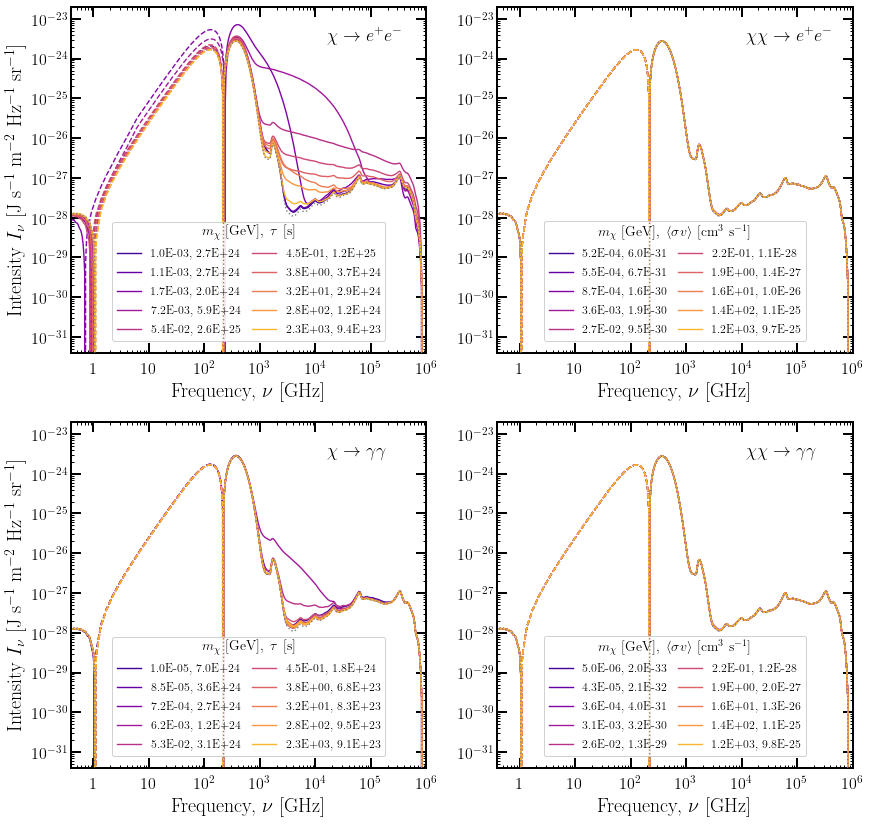

In [7]:
eng = data_list[0]['data'][-1]['distortion'].eng
hplanck = phys.hbar * 2 * np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck

figs, axs = plt.subplots(2, 2, figsize=(14, 14))
cmap = cm.plasma(np.linspace(0.1, 0.9, 40))

for i, pri in enumerate(['elec', 'phot']):
    axs[i][0].set_ylabel(
        r'Intensity $I_{\nu}$ '
        +'[J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', 
        fontsize=20
    )
    for j, DM_process in enumerate(['decay', 'swave']):
        axs[i][j].loglog()
        axs[i][j].set_xlim([4e-1, 1e6])
        axs[i][j].set_xlabel(r'Frequency, $\nu$ [GHz]', fontsize=20)

        if DM_process == 'swave':
            if pri == 'elec':
                #axs[i][j].set_ylim([1e-30, 2e-26])
                axs[i][j].set_ylim([4e-32, 2e-23])
                axs[i][j].text(0.7, 0.9, r'$\chi\chi \rightarrow e^+ e^-$', 
                                 fontsize = 18, transform = axs[i][j].transAxes)
            else:
                #axs[i][j].set_ylim([1e-30, 2e-26])
                axs[i][j].set_ylim([4e-32, 2e-23])
                axs[i][j].text(0.7, 0.9, r'$\chi\chi \rightarrow \gamma\gamma$', 
                                 fontsize = 18, transform = axs[i][j].transAxes)
        else:
            if pri == 'elec':
                #axs[i][j].set_ylim([1e-31, 8e-24])
                axs[i][j].set_ylim([4e-32, 2e-23])
                axs[i][j].text(0.72, 0.9, r'$\chi \rightarrow e^+ e^-$', 
                                 fontsize = 18, transform = axs[i][j].transAxes)
            else:
                #axs[i][j].set_ylim([1e-31, 2e-25])
                axs[i][j].set_ylim([4e-32, 2e-23])
                axs[i][j].text(0.72, 0.9, r'$\chi \rightarrow \gamma\gamma$', 
                                 fontsize = 18, transform = axs[i][j].transAxes)
#         axs[i][j].plot(BB_BF_jens[:,0], BB_BF_jens[:,1], color='gray', linestyle=':', linewidth=1.4, zorder=20)
        axs[i][j].plot(
            nu/1e9, convert * no_DM['data'][-1]['distortion'].dNdE,
            color='gray', linestyle=':', linewidth=1.4, zorder=20
        )
        k = 0 
        for data in data_list:
            if data['DM_params']['pri'] == pri and data['DM_params']['DM_process'] == DM_process: 
                if k % 4 == 0:
                    axs[i][j].plot(
                        nu/1e9, convert * data['data'][-1]['distortion'].dNdE,
                        color=cmap[k], linestyle='solid', linewidth=1.4, 
                        label=f"{data['DM_params']['mDM']/1e9:.1E}, {data['DM_params']['inj_param']:.1E}"
                    )
                    axs[i][j].plot(
                        nu/1e9, -convert * data['data'][-1]['distortion'].dNdE,
                        color=cmap[k], linestyle='--', linewidth=1.4,
                    )
                k += 1
        if DM_process=='swave':
            axs[i][j].legend(title=r'$m_\chi$ [GeV], $\,\langle \sigma v \rangle$ [cm$^3$ s$^{-1}$]', 
                             loc='lower center', title_fontsize=14, framealpha=0.9,
                             fontsize=12, ncol=2, columnspacing=1)
        else:
            axs[i][j].legend(title=r'$m_\chi$ [GeV], $\,\tau$ [s]', 
                             loc='lower center', title_fontsize=14, framealpha=0.9,
                             fontsize=12, ncol=2, columnspacing=1)
plt.savefig(fig_dir+'distortion_grid.pdf')

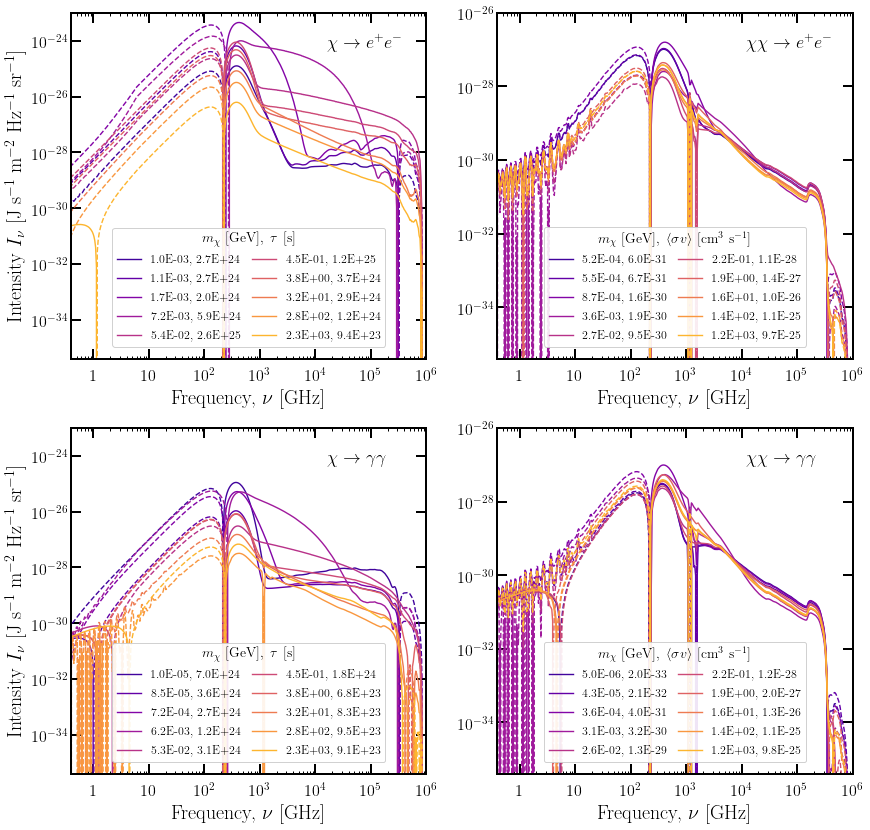

In [8]:
# Plot difference from LCDM
eng = data_list[0]['data'][-1]['distortion'].eng
hplanck = phys.hbar * 2 * np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck

figs, axs = plt.subplots(2, 2, figsize=(14, 14))
cmap = cm.plasma(np.linspace(0.1, 0.9, 40))

for i, pri in enumerate(['elec', 'phot']):
    axs[i][0].set_ylabel(
        r'Intensity $I_{\nu}$ '
        +'[J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', 
        fontsize=20
    )
    for j, DM_process in enumerate(['decay', 'swave']):
        axs[i][j].loglog()
        axs[i][j].set_xlim([4e-1, 1e6])
        axs[i][j].set_xlabel(r'Frequency, $\nu$ [GHz]', fontsize=20)

        if DM_process == 'swave':
            if pri == 'elec':
                #axs[i][j].set_ylim([1e-30, 2e-26])
                axs[i][j].set_ylim([4e-36, 1e-26])
                axs[i][j].text(0.7, 0.9, r'$\chi\chi \rightarrow e^+ e^-$', 
                                 fontsize = 18, transform = axs[i][j].transAxes)
            else:
                #axs[i][j].set_ylim([1e-30, 2e-26])
                axs[i][j].set_ylim([4e-36, 1e-26])
                axs[i][j].text(0.7, 0.9, r'$\chi\chi \rightarrow \gamma\gamma$', 
                                 fontsize = 18, transform = axs[i][j].transAxes)
        else:
            if pri == 'elec':
                #axs[i][j].set_ylim([1e-31, 8e-24])
                axs[i][j].set_ylim([4e-36, 1e-23])
                axs[i][j].text(0.72, 0.9, r'$\chi \rightarrow e^+ e^-$', 
                                 fontsize = 18, transform = axs[i][j].transAxes)
            else:
                #axs[i][j].set_ylim([1e-31, 2e-25])
                axs[i][j].set_ylim([4e-36, 1e-23])
                axs[i][j].text(0.72, 0.9, r'$\chi \rightarrow \gamma\gamma$', 
                                 fontsize = 18, transform = axs[i][j].transAxes)
        k = 0 
        for data in data_list:
            if data['DM_params']['pri'] == pri and data['DM_params']['DM_process'] == DM_process: 
                if k % 4 == 0:
                    axs[i][j].plot(
                        nu/1e9, convert * (data['data'][-1]['distortion'].dNdE - no_DM['data'][-1]['distortion'].dNdE),
                        color=cmap[k], linestyle='solid', linewidth=1.4, 
                        label=f"{data['DM_params']['mDM']/1e9:.1E}, {data['DM_params']['inj_param']:.1E}"
                    )
                    axs[i][j].plot(
                        nu/1e9, -convert * (data['data'][-1]['distortion'].dNdE - no_DM['data'][-1]['distortion'].dNdE),
                        color=cmap[k], linestyle='--', linewidth=1.4,
                    )
                k += 1
        if DM_process=='swave':
            axs[i][j].legend(title=r'$m_\chi$ [GeV], $\,\langle \sigma v \rangle$ [cm$^3$ s$^{-1}$]', 
                             loc='lower center', title_fontsize=14, framealpha=0.9,
                             fontsize=12, ncol=2, columnspacing=1)
        else:
            axs[i][j].legend(title=r'$m_\chi$ [GeV], $\,\tau$ [s]', 
                             loc='lower center', title_fontsize=14, framealpha=0.9,
                             fontsize=12, ncol=2, columnspacing=1)
plt.savefig(fig_dir+'distortion_grid_noLCDM.pdf')

# Show convergence with each iteration

phot
decay
6503.390392502643
23.850347101036473


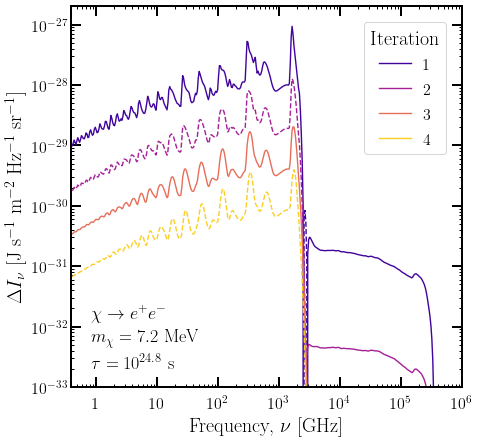

In [9]:
datum = data_list[105]

print(datum['DM_params']['pri'])
print(datum['DM_params']['DM_process'])
print(datum['DM_params']['mDM']/1e6)
print(np.log10(datum['DM_params']['inj_param']))

iter_max = len(datum['data'])-1
cmap = cm.plasma(np.linspace(0.1, 0.9, iter_max))

plt.figure(figsize=(7,7))
ax = plt.gca()
# plt.loglog()
# plt.xscale('log')

for ii in range(iter_max):
    plot_distortion(ax, datum['data'][ii+1], run2=datum['data'][ii], label=f'{ii+1}',
                    color=cmap[ii], leg=True, first=False, diff=True)
plt.ylim(1e-33,2e-27)
plt.legend(title='Iteration')
plt.text(0.05, 0.18, r'$\chi \rightarrow e^+ e^-$', fontsize=18, transform = ax.transAxes)
plt.text(0.05, 0.11, r'$m_\chi = 7.2$ MeV', fontsize=18, transform = ax.transAxes)
plt.text(0.05, 0.05, r'$\tau = 10^{24.8}$ s', fontsize=18, transform = ax.transAxes)
plt.ylabel(r'$\Delta I_{\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)

plt.savefig(fig_dir+'iterations.pdf')
plt.show()

# Ionization difference relative to RECFAST

In [10]:
# Get Recfast ionization history
rs_list = data_list[0]['data'][-1]['rs']
res_Recfast = tla.get_history(
    rs_list, high_rs=1.555e3, recfast_TLA=True,
    reion_switch=True, reion_method='Puchwein'
)

xe_Recfast = res_Recfast[:,1]

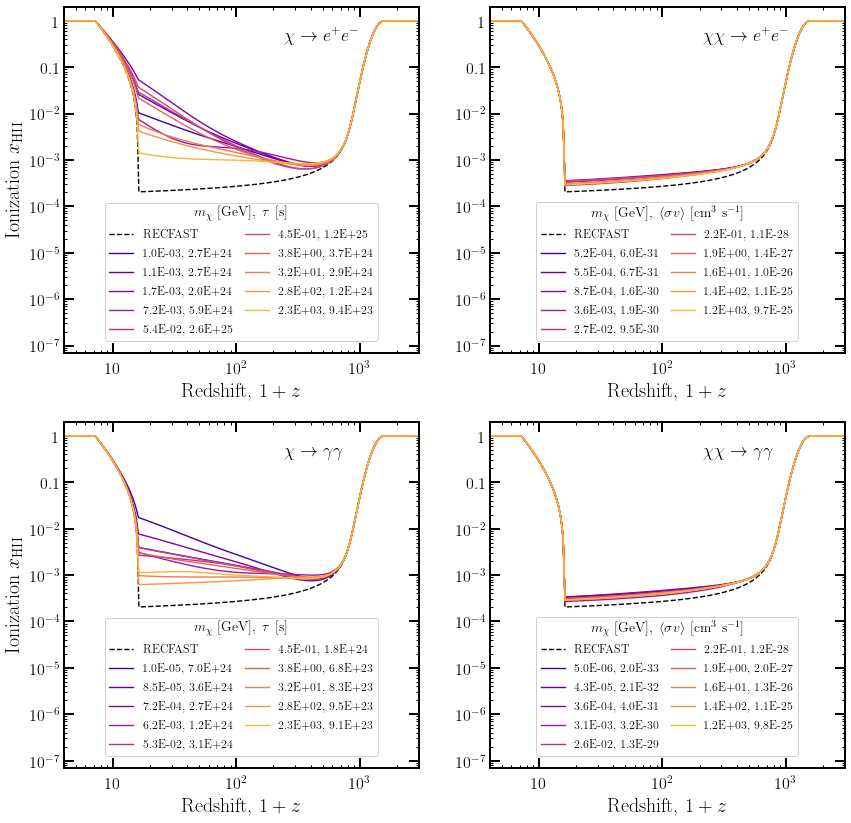

In [11]:
# Ionization histories
figs, axs = plt.subplots(2, 2, figsize=(14, 14))
cmap = cm.plasma(np.linspace(0.1, 0.9, 40))

for i, pri in enumerate(['elec', 'phot']):
    axs[i][0].set_ylabel(
        r'Ionization $x_\mathrm{HII}$', 
        fontsize=20
    )
    for j, DM_process in enumerate(['decay', 'swave']):
        axs[i][j].loglog()
        axs[i][j].set_xlim([4, 3000])
        axs[i][j].set_ylim([7e-8, 2])
        axs[i][j].set_xlabel(r'Redshift, $1+z$', fontsize=20)

        if DM_process == 'swave':
            if pri == 'elec':
                axs[i][j].text(0.6, 0.9, r'$\chi\chi \rightarrow e^+ e^-$', 
                                 fontsize = 18, transform = axs[i][j].transAxes)
            else:
                axs[i][j].text(0.6, 0.9, r'$\chi\chi \rightarrow \gamma\gamma$', 
                                 fontsize = 18, transform = axs[i][j].transAxes)
        else:
            if pri == 'elec':
                axs[i][j].text(0.62, 0.9, r'$\chi \rightarrow e^+ e^-$', 
                                 fontsize = 18, transform = axs[i][j].transAxes)
            else:
                axs[i][j].text(0.62, 0.9, r'$\chi \rightarrow \gamma\gamma$', 
                                 fontsize = 18, transform = axs[i][j].transAxes)
        axs[i][j].plot(
                    rs_list, xe_Recfast, color='k', linestyle='--', linewidth=1.4, label="RECFAST"
                )
        k = 0 
        for data in data_list:
            if data['DM_params']['pri'] == pri and data['DM_params']['DM_process'] == DM_process: 
                if k % 4 == 0:
                    axs[i][j].plot(
                        rs_list, data['data'][-1]['x'][:,0],
                        color=cmap[k], linestyle='solid', linewidth=1.4, 
                        label=f"{data['DM_params']['mDM']/1e9:.1E}, {data['DM_params']['inj_param']:.1E}"
                    )
                k += 1

        if DM_process=='swave':
            axs[i][j].legend(title=r'$m_\chi$ [GeV], $\,\langle \sigma v \rangle$ [cm$^3$ s$^{-1}$]', 
                             loc='lower center', title_fontsize=14, framealpha=0.9,
                             fontsize=12, ncol=2, columnspacing=1)
        else:
            axs[i][j].legend(title=r'$m_\chi$ [GeV], $\,\tau$ [s]', 
                             loc='lower center', title_fontsize=14, framealpha=0.9,
                             fontsize=12, ncol=2, columnspacing=1)
plt.savefig(fig_dir+'xe_grid.pdf')

/Users/viviesque/opt/anaconda3/envs/DarkHistoryEnvironment/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until


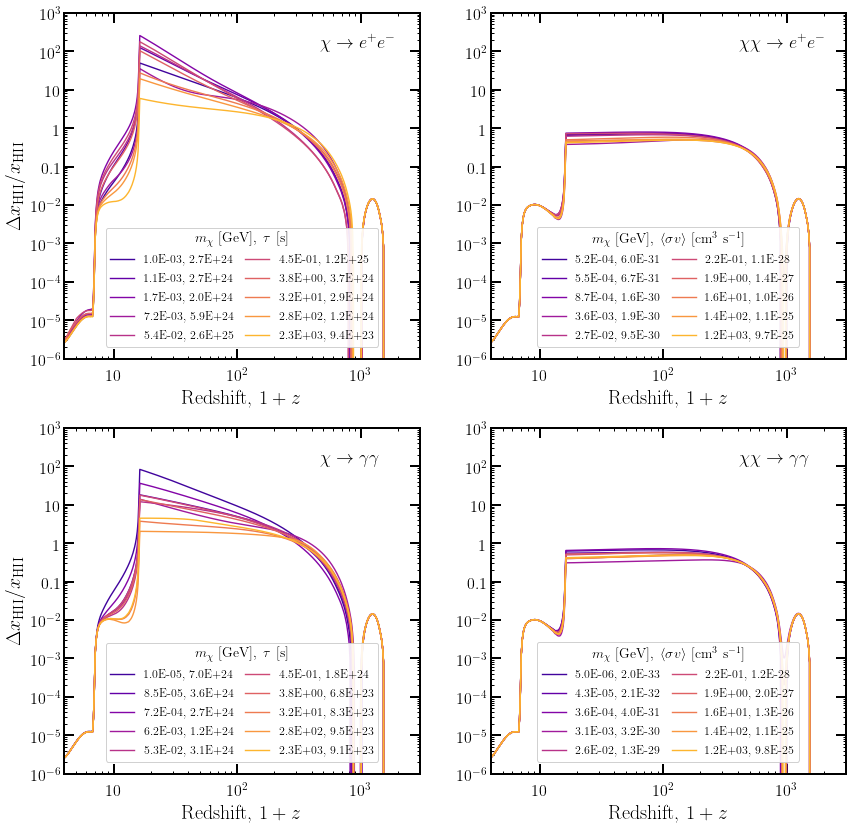

In [12]:
# Relative difference to RECFAST
figs, axs = plt.subplots(2, 2, figsize=(14, 14))
cmap = cm.plasma(np.linspace(0.1, 0.9, 40/skip))

for i, pri in enumerate(['elec', 'phot']):
    axs[i][0].set_ylabel(
        r'$\Delta x_\mathrm{HII} / x_\mathrm{HII}$', 
        fontsize=20
    )
    for j, DM_process in enumerate(['decay', 'swave']):
        axs[i][j].loglog()
        axs[i][j].set_xlim([4, 3000])
        #axs[i][j].set_ylim([1e-9, 1e-1])
        axs[i][j].set_ylim([1e-6, 1e3])
        axs[i][j].set_xlabel(r'Redshift, $1+z$', fontsize=20)

        if DM_process == 'swave':
            if pri == 'elec':
                axs[i][j].text(0.7, 0.9, r'$\chi\chi \rightarrow e^+ e^-$', 
                                 fontsize = 18, transform = axs[i][j].transAxes)
            else:
                axs[i][j].text(0.7, 0.9, r'$\chi\chi \rightarrow \gamma\gamma$', 
                                 fontsize = 18, transform = axs[i][j].transAxes)
        else:
            if pri == 'elec':
                axs[i][j].text(0.72, 0.9, r'$\chi \rightarrow e^+ e^-$', 
                                 fontsize = 18, transform = axs[i][j].transAxes)
            else:
                axs[i][j].text(0.72, 0.9, r'$\chi \rightarrow \gamma\gamma$', 
                                 fontsize = 18, transform = axs[i][j].transAxes)
        k = 0 
        for data in data_list:
            if data['DM_params']['pri'] == pri and data['DM_params']['DM_process'] == DM_process: 
                if k % 4 == 0:
                    axs[i][j].plot(
                        rs_list, (data['data'][-1]['x'][:,0] - xe_Recfast) / xe_Recfast,
                        color=cmap[k], linestyle='solid', linewidth=1.4, 
                        label=f"{data['DM_params']['mDM']/1e9:.1E}, {data['DM_params']['inj_param']:.1E}"
                    )
                k += 1

        if DM_process=='swave':
            axs[i][j].legend(title=r'$m_\chi$ [GeV], $\,\langle \sigma v \rangle$ [cm$^3$ s$^{-1}$]', 
                             loc='lower center', title_fontsize=14, framealpha=0.9,
                             fontsize=12, ncol=2, columnspacing=1)
        else:
            axs[i][j].legend(title=r'$m_\chi$ [GeV], $\,\tau$ [s]', 
                             loc='lower center', title_fontsize=14, framealpha=0.9,
                             fontsize=12, ncol=2, columnspacing=1)
plt.savefig(fig_dir+'xe_difference_grid_RECFAST.pdf')

# Ionization difference relative to original DarkHistory

In [13]:
data_list_oldDH = []
dir_str = '/Users/viviesque/Dropbox (MIT)/DarkHistory_V2/data/WQ_old_DH_with_BR_comparison/'

directory = os.fsencode(dir_str)
skip = 1

for file in tqdm(sorted(os.listdir(directory))[::skip]): 
    filename = os.fsdecode(file)
    data_list_oldDH.append(pickle.load(open(dir_str+filename, 'rb')))

/Users/viviesque/opt/anaconda3/envs/DarkHistoryEnvironment/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until


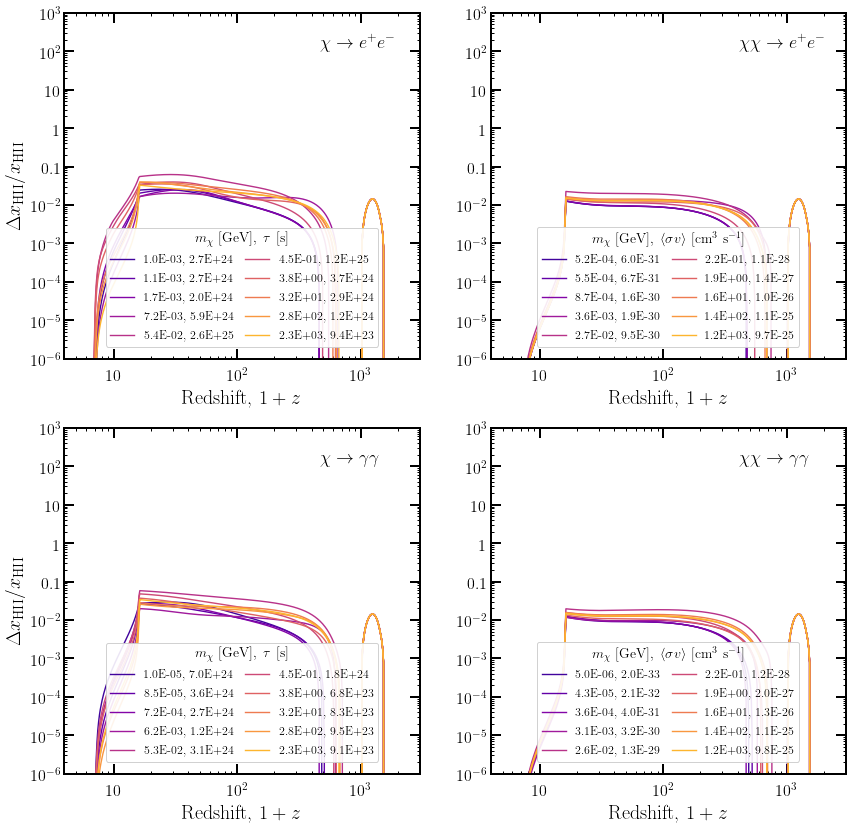

In [14]:
# Relative difference to old DH
figs, axs = plt.subplots(2, 2, figsize=(14, 14))
cmap = cm.plasma(np.linspace(0.1, 0.9, 40/skip))

for i, pri in enumerate(['elec', 'phot']):
    axs[i][0].set_ylabel(
        r'$\Delta x_\mathrm{HII} / x_\mathrm{HII}$', 
        fontsize=20
    )
    for j, DM_process in enumerate(['decay', 'swave']):
        axs[i][j].loglog()
        axs[i][j].set_xlim([4, 3000])
        #axs[i][j].set_ylim([1e-9, 1e-1])
        axs[i][j].set_ylim([1e-6, 1e3])
        axs[i][j].set_xlabel(r'Redshift, $1+z$', fontsize=20)

        if DM_process == 'swave':
            if pri == 'elec':
                axs[i][j].text(0.7, 0.9, r'$\chi\chi \rightarrow e^+ e^-$', 
                                 fontsize = 18, transform = axs[i][j].transAxes)
            else:
                axs[i][j].text(0.7, 0.9, r'$\chi\chi \rightarrow \gamma\gamma$', 
                                 fontsize = 18, transform = axs[i][j].transAxes)
        else:
            if pri == 'elec':
                axs[i][j].text(0.72, 0.9, r'$\chi \rightarrow e^+ e^-$', 
                                 fontsize = 18, transform = axs[i][j].transAxes)
            else:
                axs[i][j].text(0.72, 0.9, r'$\chi \rightarrow \gamma\gamma$', 
                                 fontsize = 18, transform = axs[i][j].transAxes)
        k = 0 
        for ii, data in enumerate(data_list):
            if data['DM_params']['pri'] == pri and data['DM_params']['DM_process'] == DM_process: 
                if k % 4 == 0:
                    axs[i][j].plot(
                        rs_list, (data['data'][-1]['x'][:,0] - data_list_oldDH[ii]['data']['x'][:,0]) / data_list_oldDH[ii]['data']['x'][:,0],
                        color=cmap[k], linestyle='solid', linewidth=1.4, 
                        label=f"{data['DM_params']['mDM']/1e9:.1E}, {data['DM_params']['inj_param']:.1E}"
                    )
                k += 1

        if DM_process=='swave':
            axs[i][j].legend(title=r'$m_\chi$ [GeV], $\,\langle \sigma v \rangle$ [cm$^3$ s$^{-1}$]', 
                             loc='lower center', title_fontsize=14, framealpha=0.9,
                             fontsize=12, ncol=2, columnspacing=1)
        else:
            axs[i][j].legend(title=r'$m_\chi$ [GeV], $\,\tau$ [s]', 
                             loc='lower center', title_fontsize=14, framealpha=0.9,
                             fontsize=12, ncol=2, columnspacing=1)
plt.savefig(fig_dir+'xe_difference_grid_oldDH.pdf')

/Users/viviesque/opt/anaconda3/envs/DarkHistoryEnvironment/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until


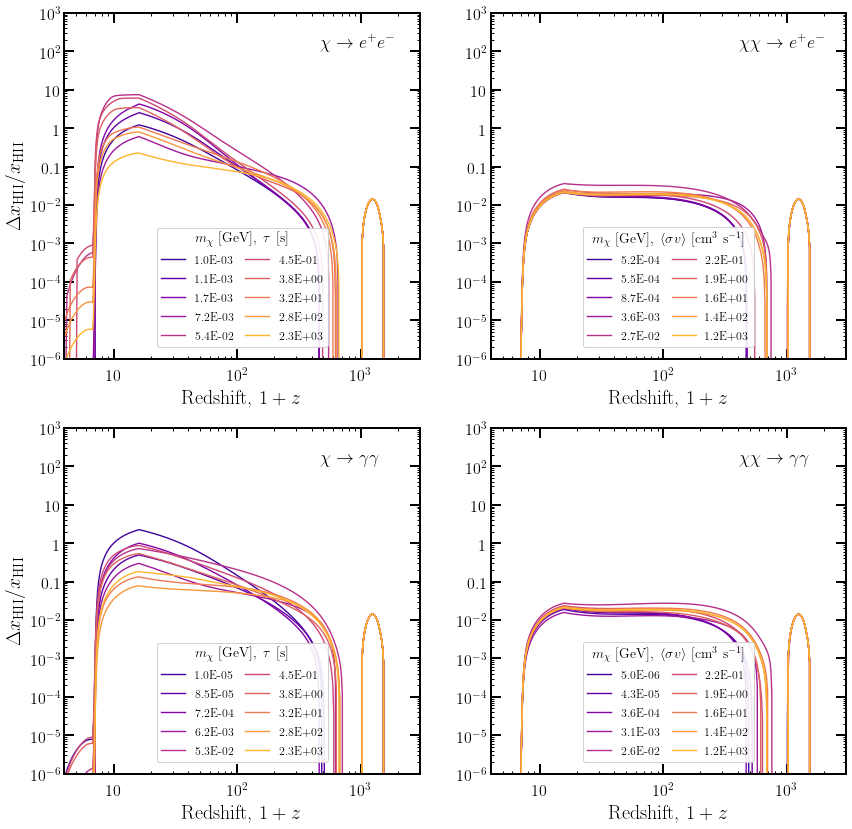

In [15]:
# Change in signal to background/no DM
figs, axs = plt.subplots(2, 2, figsize=(14, 14))
cmap = cm.plasma(np.linspace(0.1, 0.9, 40/skip))

for i, pri in enumerate(['elec', 'phot']):
    axs[i][0].set_ylabel(
        r'$\Delta x_\mathrm{HII} / x_\mathrm{HII}$', 
        fontsize=20
    )
    for j, DM_process in enumerate(['decay', 'swave']):
        axs[i][j].loglog()
        axs[i][j].set_xlim([4, 3000])
        #axs[i][j].set_ylim([1e-9, 1e-1])
        axs[i][j].set_ylim([1e-6, 1e3])
        axs[i][j].set_xlabel(r'Redshift, $1+z$', fontsize=20)

        if DM_process == 'swave':
            if pri == 'elec':
                axs[i][j].text(0.7, 0.9, r'$\chi\chi \rightarrow e^+ e^-$', 
                                 fontsize = 18, transform = axs[i][j].transAxes)
            else:
                axs[i][j].text(0.7, 0.9, r'$\chi\chi \rightarrow \gamma\gamma$', 
                                 fontsize = 18, transform = axs[i][j].transAxes)
        else:
            if pri == 'elec':
                axs[i][j].text(0.72, 0.9, r'$\chi \rightarrow e^+ e^-$', 
                                 fontsize = 18, transform = axs[i][j].transAxes)
            else:
                axs[i][j].text(0.72, 0.9, r'$\chi \rightarrow \gamma\gamma$', 
                                 fontsize = 18, transform = axs[i][j].transAxes)
        k = 0 
        for ii, data in enumerate(data_list):
            if data['DM_params']['pri'] == pri and data['DM_params']['DM_process'] == DM_process: 
                if k % 4 == 0:
                    axs[i][j].plot(
                        rs_list, (data['data'][-1]['x'][:,0] - data_list_oldDH[ii]['data']['x'][:,0]) / phys.x_std(data['data'][-1]['rs']),
                        color=cmap[k], linestyle='solid', linewidth=1.4, label=f"{data['DM_params']['mDM']/1e9:.1E}"
                    )
                k += 1

        if DM_process=='swave':
            axs[i][j].legend(title=r'$m_\chi$ [GeV], $\,\langle \sigma v \rangle$ [cm$^3$ s$^{-1}$]', 
                             loc='lower center', title_fontsize=14, framealpha=0.9,
                             fontsize=12, ncol=2, columnspacing=1)
        else:
            axs[i][j].legend(title=r'$m_\chi$ [GeV], $\,\tau$ [s]', 
                             loc='lower center', title_fontsize=14, framealpha=0.9,
                             fontsize=12, ncol=2, columnspacing=1)
plt.savefig(fig_dir+'xe_difference_grid_StB.pdf')